In [68]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import os

from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

In [69]:
path = '/kaggle/input/ofa-ai-mastery-computer-vision'

In [70]:
names = []
nums = []
data = {'Nama Kelas':[],'Jumlah Sampel':[]}

for i in os.listdir(path+'/train'):
    nums.append(len(os.listdir(path+'/train/'+i)))
    names.append(i)

data['Nama Kelas']+=names
data['Jumlah Sampel']+=nums

df = pd.DataFrame(data)
df

,Nama Kelas,Jumlah Sampel
0,horse,600
1,dog,900
2,cat,700
3,deer,600


<AxesSubplot:xlabel='Nama Kelas', ylabel='Jumlah Sampel'>

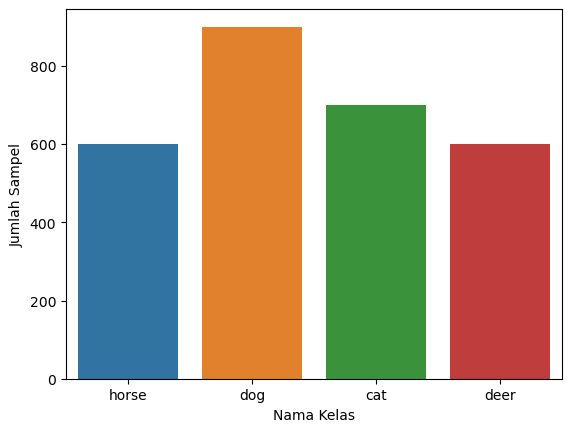

In [71]:
sns.barplot(x=df['Nama Kelas'],y=df['Jumlah Sampel'])

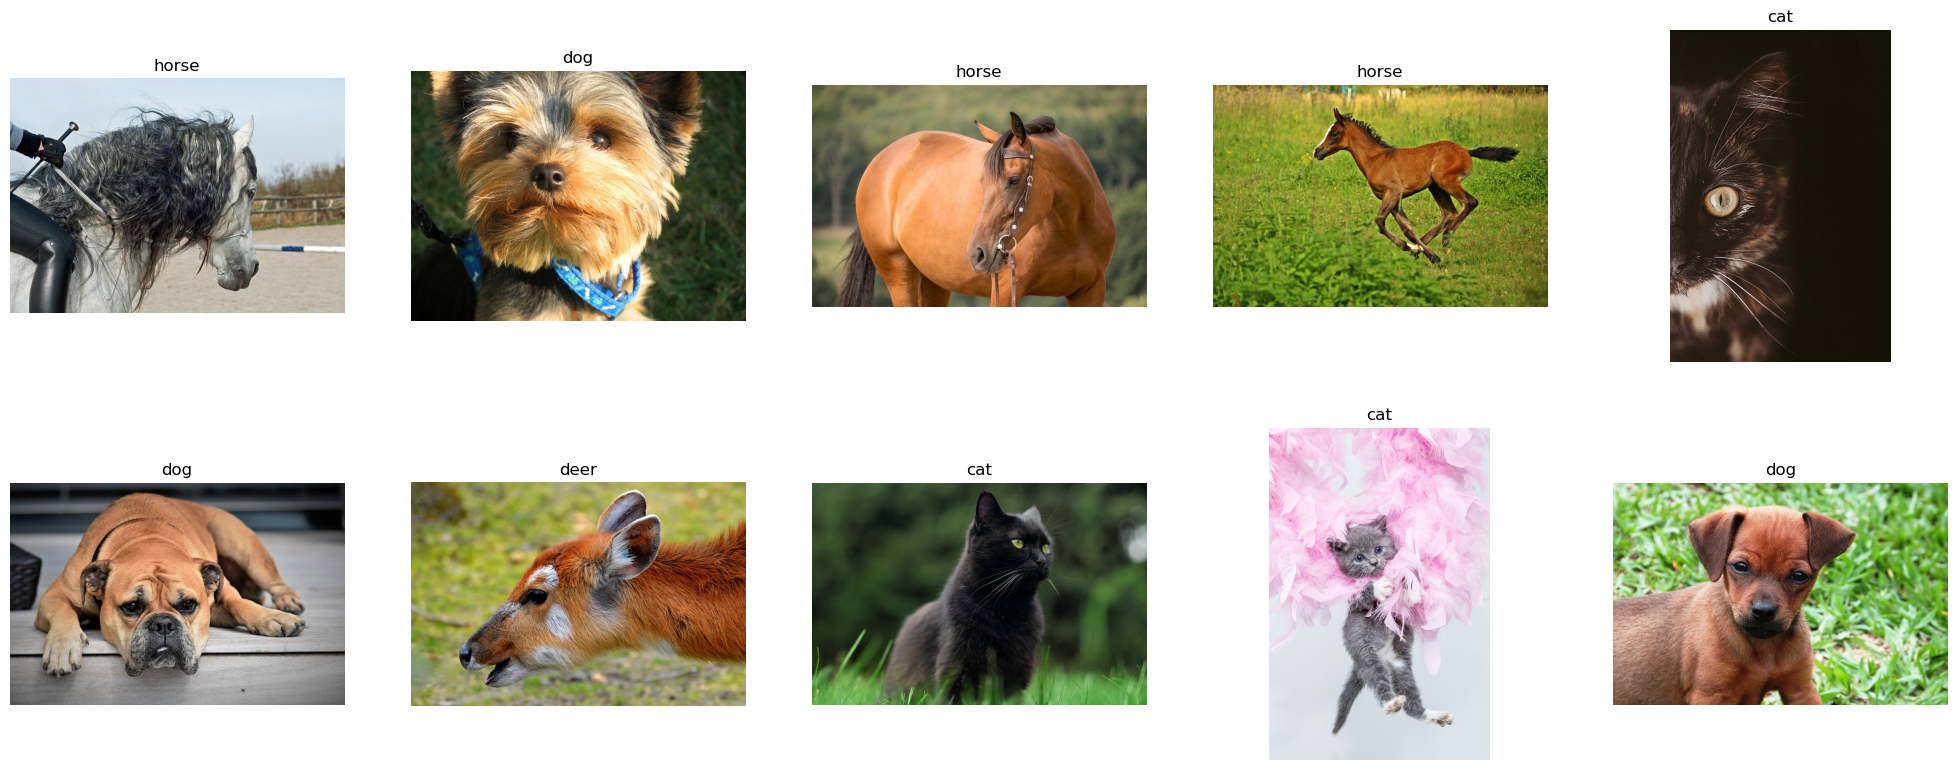

In [72]:
classes = os.listdir(path+'/train')

plt.figure(figsize=(25 , 25))
for x in range(10):
    i = random.randint(0,3)                    # getting the class
    images = os.listdir(path+'/train'+'/'+classes[i])
    j = random.randint(0,600)                  # getting the image
    image = cv2.imread(path+'/train'+'/'+classes[i]+'/'+images[j])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(5, 5, x + 1)
    plt.imshow(image)
    plt.title(classes[i])
    plt.axis("off")

plt.show()

# 3. Preparing the data

In [73]:
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255 , rotation_range=20,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                horizontal_flip=True, validation_split=0.2)

In [74]:
train_ds = image_datagen.flow_from_directory(
        path+'/train',
        subset='training',
        target_size=(250 , 250),
        batch_size=30)

val_ds = image_datagen.flow_from_directory(
        path+'/train',
        subset='validation',
        target_size=(250 , 250),
        batch_size=30 )

Found 2240 images belonging to 4 classes.
Found 560 images belonging to 4 classes.


# 4. Building the model

In [75]:
# i'll be using inception_v3 for this model , along with 2 extra dense layers and the output layer

mobilenet = tf.keras.applications.mobilenet.MobileNet(input_shape=(250 , 250, 3),
                                           include_top=False,
                                           weights='imagenet')

model = Sequential()
model.add(mobilenet)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(4, activation="softmax" , name="classification"))

In [76]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005,momentum=0.9), 
            loss='categorical_crossentropy',
            metrics = ['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_7   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_7 (Flatten)         (None, 1024)              0         
                                                                 
 dense_14 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_15 (Dense)            (None, 512)               524800    
                                                                 
 classification (Dense)      (None, 4)                

# 5. Training and evaluating

In [77]:
history = model.fit(train_ds , validation_data = val_ds , epochs = 20)

Epoch 1/20
75/75 [==============================] - 408s 5s/step - loss: 0.8036 - accuracy: 0.7054 - val_loss: 0.4017 - val_accuracy: 0.8875
Epoch 2/20
75/75 [==============================] - 382s 5s/step - loss: 0.2880 - accuracy: 0.9228 - val_loss: 0.2513 - val_accuracy: 0.9411
Epoch 3/20
75/75 [==============================] - 401s 5s/step - loss: 0.2142 - accuracy: 0.9330 - val_loss: 0.2062 - val_accuracy: 0.9393
Epoch 4/20
75/75 [==============================] - 402s 5s/step - loss: 0.1611 - accuracy: 0.9513 - val_loss: 0.1735 - val_accuracy: 0.9446
Epoch 5/20
75/75 [==============================] - 401s 5s/step - loss: 0.1339 - accuracy: 0.9634 - val_loss: 0.1428 - val_accuracy: 0.9554
Epoch 6/20
75/75 [==============================] - 398s 5s/step - loss: 0.1103 - accuracy: 0.9696 - val_loss: 0.1665 - val_accuracy: 0.9518
Epoch 7/20
75/75 [==============================] - 418s 6s/step - loss: 0.1045 - accuracy: 0.9688 - val_loss: 0.1428 - val_accuracy: 0.9500
Epoch 8/20
75

19/19 [==============================] - 24s 1s/step - loss: 0.1266 - accuracy: 0.9607


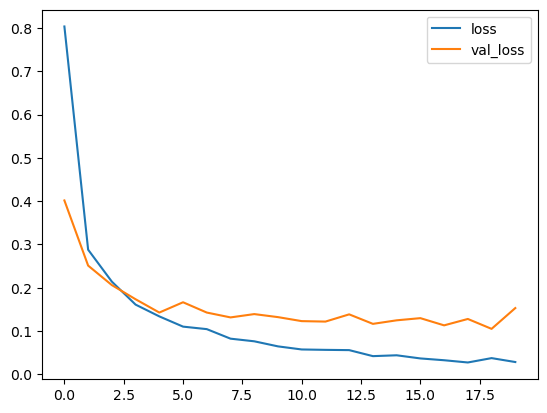

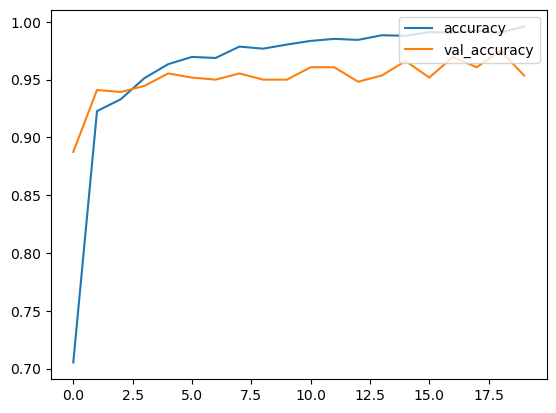

In [78]:
model.evaluate(val_ds)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()

# 6. Preparing for submission

In [79]:
sub_csv ='/kaggle/input/ofa-ai-mastery-computer-vision/Sample_submission.csv'
path_test = path = '/kaggle/input/ofa-ai-mastery-computer-vision/test/test'

In [80]:
df_sub = pd.read_csv(sub_csv)
image_id = df_sub['ID']
df_sub.head(10)

,ID,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [82]:
# setiap gambar akan diperlakukan secara individual dan disimpan dalam daftar yang kemudian digabungkan dengan id korespondensinya

from tensorflow.keras.preprocessing.image import load_img


# making a list for our predictions
labels = []


for i in image_id:
    image = load_img(path_test+'/'+str(i)+'.jpg', target_size=(250, 250))
    img = np.array(image)
    img = img / 255.0
    img = img.reshape(1,250,250,3)
    label = model.predict(img)
    label_id = label[0].tolist()
    
    labels.append(label_id.index(max(label_id)))


1/1 [==============================] - 0s 71ms/step


In [85]:
# saya akan mengganti kolom kosong sebelumnya dengan prediksi baru    
    
df_sub['Label'] = labels
df_sub.head(20)

,ID,Label
0,1,1
1,2,0
2,3,2
3,4,3
4,5,2
5,6,1
6,7,3
7,8,0
8,9,3
9,10,2


In [86]:
# menyimpan berkas

df_sub.to_csv('submission.csv',index=False)